In [7]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [16]:
ds = xr.open_dataset("/Volumes/Alsakan/hoth_archive/old_documents_12-01-2018/NCL_SOURCE/ncl_ncarg-6.2.0/ni/src/examples/data/cdf/chi200_ud_smooth.nc", decode_times=False)

In [17]:
ds

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 182)
Coordinates:
  * lat      (lat) float32 -87.8638 -85.09653 -82.31291 ... 85.09653 87.8638
  * lon      (lon) float32 0.0 2.8125 5.625 8.4375 ... 351.5625 354.375 357.1875
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 178.0 179.0 180.0 181.0
Data variables:
    gw       (lat) float32 ...
    date     (time) float64 ...
    CHI      (time, lon) float32 ...
Attributes:
    title:    Time Filtered CHI for Hovmueller Demo
    source:   /fs/cgd/home0/shea/ncld/hovmu/chi2chiFilternc.ncl

In [48]:
# same as in indices_nino_1.ipynb
def printVarSummary(da):
    n = da.name
    if hasattr(da, 'units'):
        u = da.units
    else:
        u = None
    if hasattr(da, 'long_name'):
        lng = da.long_name
    else:
        lng = "NO LONG NAME"
    c = []
    for i in da.dims:
        if i in da.coords:
            c.append(f"\t dim: {i} with coordinate of shape {da.coords[i].shape}")
        else:
            c.append(f"\t dim: {i} with no coordinate variable")
    mn = da.min().values.item()
    mx = da.max().values.item()
    print(f"{n} ({u})\n  {lng}\n  minimum: {mn}\n  maximum: {mx}")
    for i in c:
        print(i)




In [52]:
scale = 1.e6                                     # create scale factor
tmp   = ds['CHI']                                # get chi
tmp   = tmp/scale                                # scale for convenience
printVarSummary(tmp)
#===============================
# filter over time dimension
#===============================
wgt  = np.array([1., 3., 5., 6., 5., 3., 1.])            # weights
wgt  = wgt/sum(wgt)                              # normalize wgts
print(wgt)
wgt = xr.DataArray(wgt, dims=['window'])

#===============================
# return variable to original dimension  order for plotting
#===============================
#chov      = yhov(time|:,lon|:)                   # move to 2D array for plot
#chov&time = tmp&time                                # set coordinate
#chov&lon  = tmp&lon
#copy_VarAtts(tmp,chov)                           # copy attributes


CHI (None)
  NO LONG NAME
  minimum: -8.177284240722656
  maximum: 10.425189018249512
	 dim: time with coordinate of shape (182,)
	 dim: lon with coordinate of shape (128,)
[0.04166667 0.125      0.20833333 0.25       0.20833333 0.125
 0.04166667]
None (None)
  NO LONG NAME
  minimum: -7.98805848757426
  maximum: 9.950583299001059
	 dim: time with coordinate of shape (182,)
	 dim: lon with coordinate of shape (128,)


# Filter: weighted rolling average

We are applying `wgt` to the data along the time dimension as a weighed rolling average. That essentially means that the solution at some time, `t` should be

\begin{equation}
y(t) = \sum_{i = t-(m/2)}^{i = t + (m/2)} w_i x_i
\end{equation}

where $m$ is the size of the filter (`len(wgt)`). And I'm assuming normalized weights, so $\sum_i w_i = 1$.


## methods

There are numerous ways to do this operation. I will show three of them in the next cell that all give the same answer. Really, I think these all actually boil down to even running the same underlying code, or nearly so. The first uses just xarray; it makes the rolling object that is then operated on with construct and the dot product with `wgt`. I find this method to be a little hard to write and to understand. The other two methods use numpy's convolve function. The complication is that convolve works only on 1D arrays, so we have to loop over all the longitudes. The first approach uses `apply_along_axis`  and an anonymous function (`lambda`) to do that. The second approach (commented) uses a loop over longitudes to do the same operation. The two approaches give the same answer because they do the same convolution, but the first one is faster.

The xarray version keeps the coordinates in the result, but the numpy ways both result in a plain numpy array. So I show how to copy the coordinate information from the original array to the result.

In [91]:
%%time

#
# Apply weighed rolling mean with xarray:
#
yhov0 = tmp.rolling(time=len(wgt), center=True).construct("window").dot(wgt)
printVarSummary(yhov0)

#
# using numpy only
#
yhov_np = np.apply_along_axis(lambda m: np.convolve(m, wgt, mode='same'), axis=0, arr=tmp)

# Equivalent to this loop (but a bit faster):
# yhov_np = np.zeros(tmp.shape)
# for x in range(len(tmp.lon)):
#     yhov_np[:,x] = np.convolve(tmp[:,x].values, wgt.values, mode='same')

f"Min: {np.nanmin(yhov_np)}, Max: {np.nanmax(yhov_np)}" # Matches NCL values

# copy coordinates from tmp:
yhov = xr.DataArray(yhov_np, dims=tmp.dims, coords=tmp.coords)
yhov.name = "CHI"
yhov.attrs["long_name"] = "smoothed CHI"
printVarSummary(yhov)

None (None)
  NO LONG NAME
  minimum: -7.873470683892568
  maximum: 9.543959220250448
	 dim: time with coordinate of shape (182,)
	 dim: lon with coordinate of shape (128,)
CHI (None)
  smoothed CHI
  minimum: -7.873470683892568
  maximum: 9.543959220250448
	 dim: time with coordinate of shape (182,)
	 dim: lon with coordinate of shape (128,)
CPU times: user 18.6 ms, sys: 1.36 ms, total: 19.9 ms
Wall time: 18.9 ms


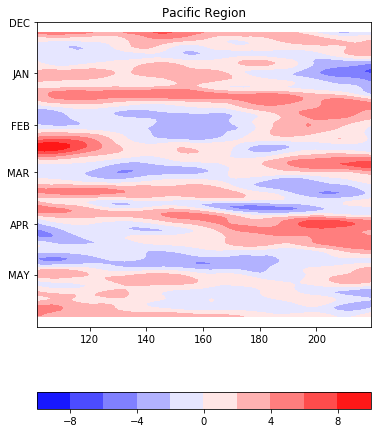

In [96]:
#
# create plot (mimic the NCL one)
#
fig, ax = plt.subplots(figsize=(6,8))

ax.set_title("Pacific Region")
levels = np.arange(-10, 12, 2)
cnFillPalette        = "bwr"
ax.set_yticks([0. ,  30.,  61.,   89., 120., 150.])
ax.set_yticklabels(["DEC","JAN","FEB","MAR" ,"APR","MAY"])
ax.invert_yaxis()


meshlon, meshtime = np.meshgrid(yhov0['lon'].sel(lon=slice(100,220)).values, yhov0['time'].values, )
img = ax.contourf(meshlon, meshtime, yhov0.sel(lon=slice(100,220)), cmap=cnFillPalette, levels=levels) 

fig.colorbar(img, orientation='horizontal')

fig.savefig("../../docs/assets/filters_1_py.png")